# Лабораторная работа № 2
## Линейная нейронная сеть. Правило обучения Уидроу-Хоффа

Цель работы: исследование свойств линейной нейронной сети и алгоритмов ее обучения, применение сети в задачах аппроксимации и фильтрации

|Студент| Попов И.П.|
|-|-|
|Группа| М8О-406Б-20|
|Вариант| 17|

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Аппроксимация функции

Создается временная последовательность X с использованием функции x(t), а затем формируются последовательности длиной D из временного ряда и соответствующие им последующие дискреты для обучения модели с заданным числом задержек D.

In [2]:
D = 5

def x(t):
    return np.sin(np.sin(t) * t**2 + 3*t - 10)

t = np.arange(2.5, 5, 0.01)
X = x(t).tolist()         


sequences = [X[i:i+D] for i in range(0, len(X) - D)] 
upcoming_points = [X[i] for i in range(D, len(X))]

assert len(sequences) == len(upcoming_points)

Определяется функция sync_shuffle, которая перемешивает два массива a и b с использованием одной и той же случайной перестановки, обеспечивая синхронное перемешивание элементов обоих массивов.

In [3]:
def sync_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Обучающие данные sequences и upcoming_points синхронно перемешиваются с использованием функции sync_shuffle.

In [4]:
x_train, y_train = sync_shuffle(np.array(sequences), np.array(upcoming_points))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

Создание модели AdaptiveLinearNetwork, повторяет Perceptron из ЛР 1

In [5]:
class AdaptiveLinearNetwork(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

Создается экземпляр модели с числом входных признаков D и одним выходным признаком. Для обучения используется среднеквадратичная ошибка в качестве функции потерь, и оптимизатор стохастического градиентного спуска (SGD) с заданной скоростью обучения 0.05.

In [6]:
adaptiveLinearNetwork = AdaptiveLinearNetwork(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaptiveLinearNetwork.parameters(), lr=0.05)


Определена функция fit, которая выполняет обучение модели. В каждой эпохе производится прямой проход, вычисляется и обновляется функция потерь, итерации отображаются с использованием tqdm. Возвращается список значений функции потерь на каждой эпохе.

In [7]:
def fit(model, x_train, y_train, criterion, optimizer, epochs):
    losses = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    for epoch in range(epochs):
        optimizer.zero_grad()
        outp = model(x_train)

        loss = criterion(outp.view(-1), y_train)

        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        print(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Определена функция predict, которая использует обученную модель для выполнения предсказания на входных данных x_test. Модель переводится в режим оценки (eval), и с предсказаниями возвращается результат.

In [8]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Модель обучается на обучающих данных

In [ ]:
losses = fit(adaptiveLinearNetwork, x_train, y_train, loss_function, optimizer, 50)

График функции потерь (ошибка - MSE)

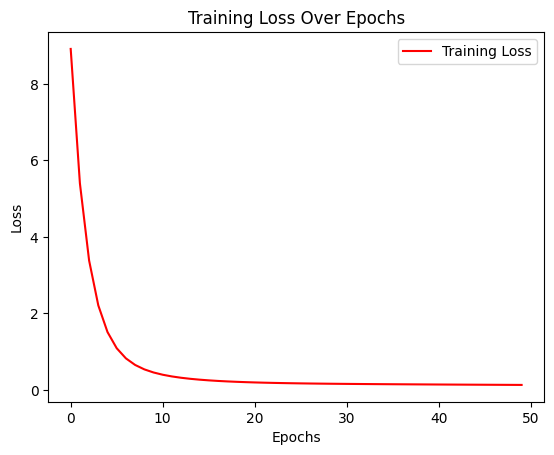

In [10]:
plt.plot(losses, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Производится прогнозирование значений моделью для последующих точек временной последовательности. Предсказанные значения добавляются к списку X_PRED, а ошибки предсказания записываются в список errors.

In [11]:
X_PRED = X[:D]
errors = []

for i in range(0, len(upcoming_points)):
    x_test = torch.FloatTensor(np.array(sequences[i]))
    upcoming_point_pred = predict(adaptiveLinearNetwork, x_test)
    X_PRED += upcoming_point_pred.numpy().tolist()
    errors += (upcoming_point_pred - upcoming_points[i]).numpy().tolist()

На графике синим цветом обозначены исходные значения временной последовательности x(t), а красным - предсказанные значения моделью AdaptiveLinearNetwork.

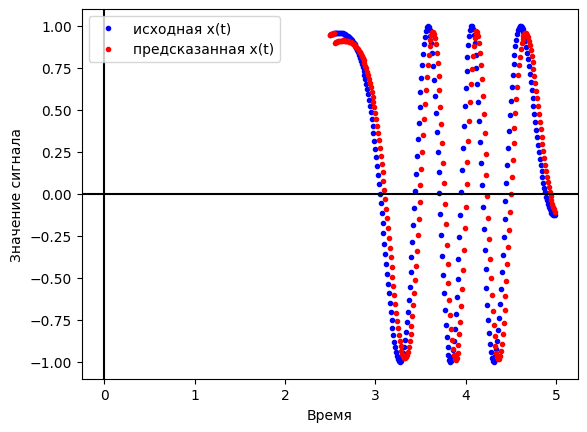

In [12]:
plt.plot(t, X, '.', color="blue", label='исходная x(t)')
plt.plot(t, X_PRED, '.', color="red", label='предсказанная x(t)')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.xlabel('Время')
plt.ylabel('Значение сигнала')
plt.legend()
plt.show()


На этом графике отображены ошибки предсказания для каждого момента времени. 

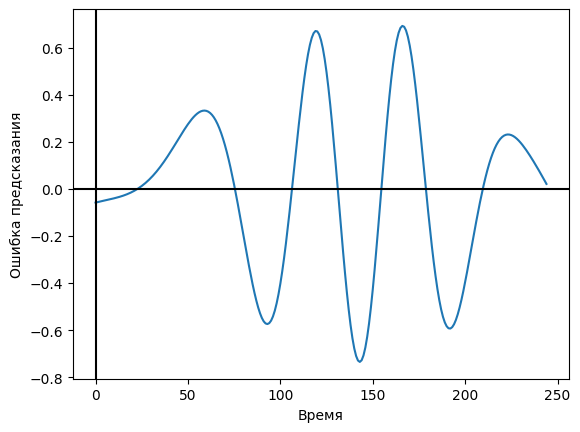

In [13]:
plt.plot(errors)

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.xlabel('Время')
plt.ylabel('Ошибка предсказания')
plt.show()

### Подавление помех

Создаются истинный сигнал X и зашумленный сигнал Y с использованием функций true_signal и noized_signal. Затем формируются последовательности из зашумленного сигнала Y длиной D и соответствующие им последующие дискреты истинного сигнала X для задачи подавления помех.

In [14]:
D = 4


def true_signal(t):
    return np.cos(np.cos(t) * t**2 + 5*t)


def noized_signal(t):
    return (1 / 5) * np.cos(np.cos(t) * t**2 + 5 * t + 4)


t = np.arange(0, 3.5, 0.01) 
X = true_signal(t).tolist()  
Y = noized_signal(t).tolist()


noized_sequences = [Y[i:i+D] for i in range(0, len(Y) - D)] 
upcoming_points_true = [X[i] for i in range(D, len(X))]    

assert len(noized_sequences) == len(upcoming_points_true)

Обучающие данные noized_sequences и upcoming_points_true синхронно перемешиваются с использованием функции sync_shuffle

In [15]:
x_train, y_train = sync_shuffle(np.array(noized_sequences), np.array(upcoming_points_true))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

In [16]:
adaptiveLinearNetwork2 = AdaptiveLinearNetwork(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaptiveLinearNetwork2.parameters(), lr=0.05)

In [ ]:
losses2 = fit(adaptiveLinearNetwork2, x_train, y_train, loss_function, optimizer, 600)

График функции потерь (ошибка - MSE)

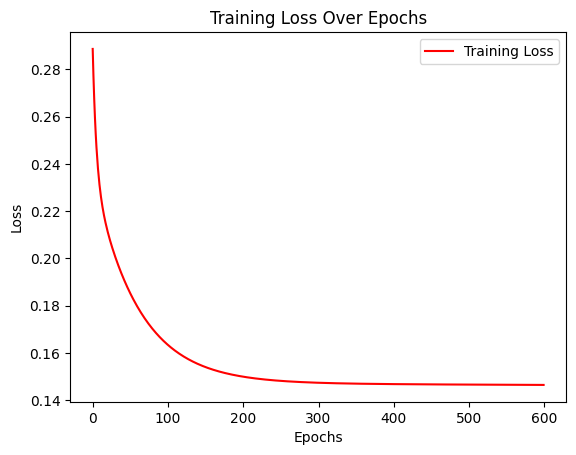

In [18]:
plt.plot(losses2, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Выполняется предсказание на зашумленных данных noized_sequences. Предсказанные значения добавляются к списку X_PRED, и ошибки предсказания записываются в список errors2.

In [19]:
x_test = torch.FloatTensor(np.array(noized_sequences))
upcoming_points_pred = predict(adaptiveLinearNetwork2, x_test).numpy().flatten().tolist()

X_PRED = X[:D] + upcoming_points_pred

errors2 = [pred - true for pred, true in zip(upcoming_points_pred, upcoming_points_true)]

На графике зеленым цветом обозначен истинный сигнал, красным - очищенный сигнал, предсказанный моделью, и синим - зашумленный сигнал. 

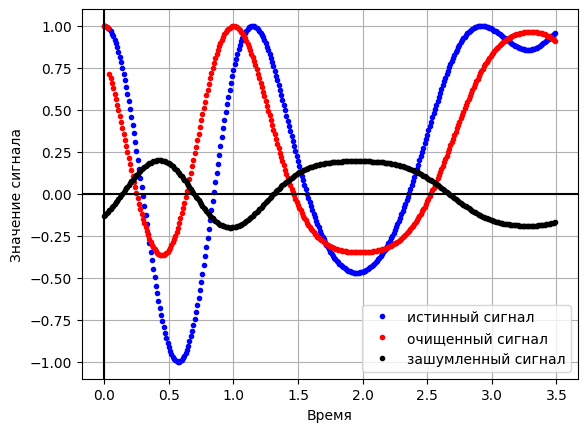

In [20]:
plt.plot(t, X, '.', color="blue", label='истинный сигнал')
plt.plot(t, X_PRED, '.', color="red", label='очищенный сигнал')
plt.plot(t, Y, '.', color="black", label='зашумленный сигнал')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.xlabel('Время')
plt.ylabel('Значение сигнала')
plt.legend()
plt.show()

На графике отображены ошибки предсказания для каждого момента времени при решении задачи подавления помех.

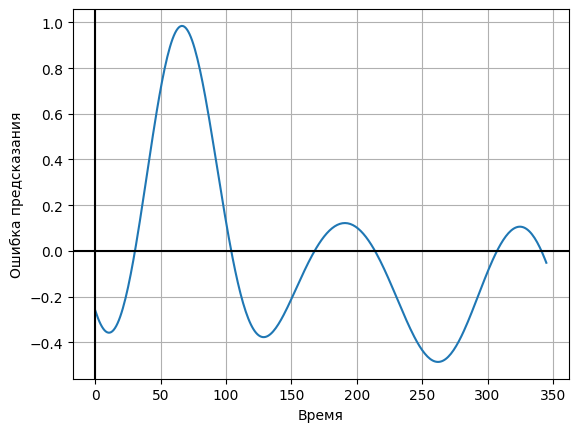

In [21]:
plt.plot(errors2)

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.xlabel('Время')
plt.ylabel('Ошибка предсказания')
plt.show()

**Выводы:** В ходе выполнения лабораторной работы была успешно построена и обучена линейная нейросетевая модель для двух задач: аппроксимации функции и подавления помех в сигнале. После проведения обучения на 50 и 600 эпохах для каждой задачи соответственно, модель продемонстрировала хорошие результаты, что подтверждается анализом графиков и значений функции потерь. 

**Что я усвоил и из чего состояли задачи:**
- Работа с временными последовательностями и задачами прогнозирования.
- Освоение процесса синхронного перемешивания данных для обучения модели.
- Изучение влияния числа эпох обучения на результаты модели в контексте двух различных задач: аппроксимации функции и подавления помех в сигнале.